# Amplitude embedding (simulator)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Amplitude embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 4 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = 1 #np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 7.46751949e-03-3.6419486e-03j  1.79699704e-03+3.5260007e-04j
   2.42276058e+01+4.6963806e+01j  7.46084517e-03-2.0677105e-02j]
 [-3.40827857e-03+3.6717276e-03j  5.91830350e-04-2.6114842e-02j
  -3.64206196e-03+1.1004703e-02j  1.61408670e-02-1.9153152e-02j]
 [ 4.36700249e+01+8.4847504e+01j  2.64459753e+00+4.9496635e+01j
   2.23283302e-02-1.5873365e-03j  4.12674714e-03-6.6658943e-03j]
 [ 1.58646470e-03+2.0319721e-02j -1.10263415e-02+1.5704198e-02j
  -2.39157840e-03+3.1614597e-03j  7.10986322e-03+1.8777868e-03j]]


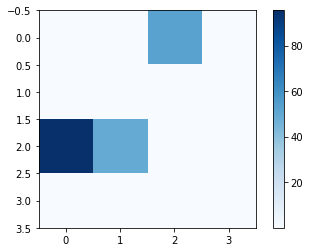

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[  70.59037 +181.2862j     68.96297  +35.290348j   65.24877  +82.40228j
   -30.099426 +40.492588j]
 [ -22.168402 -87.41045j  -117.37718 -129.14587j   -16.76377  +11.651436j
   -18.407467-134.47972j ]
 [  70.580444+181.26526j    68.94081  +35.203327j   65.290115 +82.27059j
   -30.09412  +40.54031j ]
 [ -22.025091 -87.381645j -117.32303 -129.19493j   -16.871859 +11.597648j
   -18.363659-134.44563j ]]


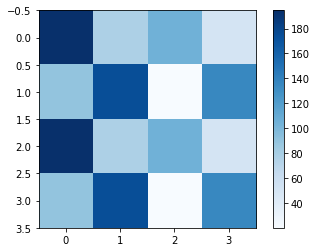

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [6]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 2.574075e-13
Imaginaries MSE: 2.995224e-13


## 3) Data encoding: amplitude embedding (non-conventional domain)

In [7]:
# Amplitude embedding encodes a normalized 2^n-dimensional feature vector into the state of n qubits
# --> uses log2(n) qubits for n classical data

n = visibilities.shape[0]*visibilities.shape[1]
data = visibilities.flatten()

#normalization to prepare a qstate with measurement probabilites summing up to 1 (SUM (amplitudes²) = 1)
norm = qml.math.sum(qml.math.abs(data) ** 2)
normalized_data = data / qml.math.sqrt(norm)

wires = range(int(math.log2(n))) # set the number of qubits (no padding needed if outputs an integer=integer.0)
amp_dev = qml.device('default.qubit', wires)

# encoding
@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires) # normalize = True
    return qml.state() #qml.expval(qml.PauliZ(wires=wires))

readout = amp_encoding(normalized_data).astype('complex64')
readout = readout*qml.math.sqrt(norm) # denormalization of the measurements outcomes
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])
print(readout)

[[  70.59036 +181.2862j     68.96297  +35.290348j   65.248764 +82.40228j
   -30.099426 +40.492588j]
 [ -22.1684   -87.410446j -117.37718 -129.14587j   -16.76377  +11.651436j
   -18.407467-134.4797j  ]
 [  70.58044 +181.26524j    68.9408   +35.203323j   65.290115 +82.27059j
   -30.09412  +40.54031j ]
 [ -22.025091 -87.38164j  -117.32303 -129.19493j   -16.871859 +11.597648j
   -18.363659-134.44563j ]]


## 4) Applying 2D IFT (fidelity test)

In [8]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 1.8964212e-12
Imaginaries MSE: 1.8025457e-12


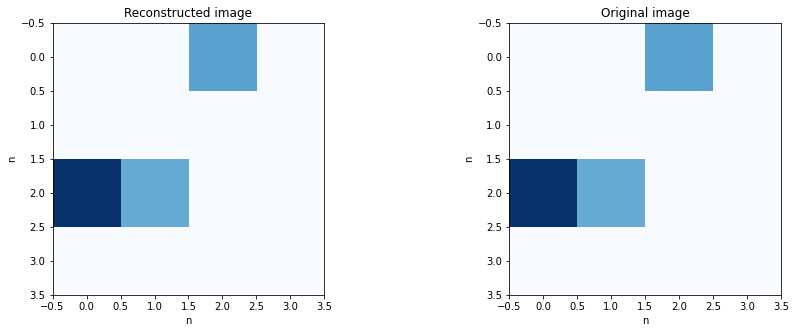

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')